# Task 1-2. Feature Analysis¶
For each custom feature set (text-feature set and speech feature set), formulate and test a hypothesis about the features (visually or statistically). Observe if the results are in accordance with your hypothesis or not. Give an explanation about your thinking behind the observed behavior.

For example, testing whether the LIWC feature “Insight”, which is associated with words such as “think” and “know”, or the bigram “I think” are useful in predicting the dialogue act “Statement-opinion”. This hypothesis could be tested by plotting average values of the LIWC “insight features or “I think” bigram for the top 10 dialogue acts.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
speech_train = pd.read_csv("speech_features_train.csv")
speech_valid = pd.read_csv("speech_features_valid.csv")
speech_test = pd.read_csv("speech_features_test.csv")

In [6]:
text_train = pd.read_csv("text_features_train.csv")
text_valid = pd.read_csv("text_features_valid.csv")
text_test = pd.read_csv("text_features_test.csv")

In [8]:
print(speech_train.columns)

Index(['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'Min Pitch',
       'Max Pitch', 'Mean Pitch', 'Std Pitch', 'Min Intensity',
       'Max Intensity', 'Mean Intensity', 'Std Intensity', 'Speaking Rate',
       'Jitter', 'Shimmer', 'HNR'],
      dtype='object')


In [10]:
print(text_train.columns)

Index(['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'function',
       'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron',
       'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj',
       'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo',
       'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male',
       'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual',
       'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk',
       'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion',
       'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler',
       'utt_len'],
      dtype='object')


In [20]:
# hypothesis 1
def speaker_consistency_plot(df, feature='Mean Pitch'):
    # speaker mean
    speaker_mean = df.groupby(['dialog_id', 'speaker'])[feature].mean().reset_index()
    speaker_mean = speaker_mean.rename(columns={feature: 'speaker_mean'})

    df_merged = df.merge(speaker_mean, on=['dialog_id', 'speaker'])
    df_merged['error'] = (df_merged[feature] - df_merged['speaker_mean']).abs()

    plt.figure(figsize=(10, 5))
    sns.histplot(df_merged['error'], bins=50, kde=True)
    plt.title(f'Distribution of |{feature} - speaker_mean|')
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.show()

    print(f"{feature} mean error: {df_merged['error'].mean():.4f}")


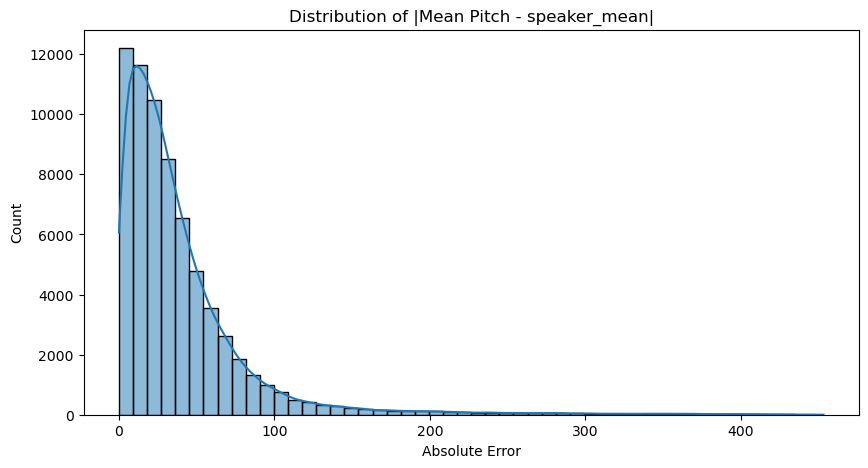

Mean Pitch mean error: 39.2210


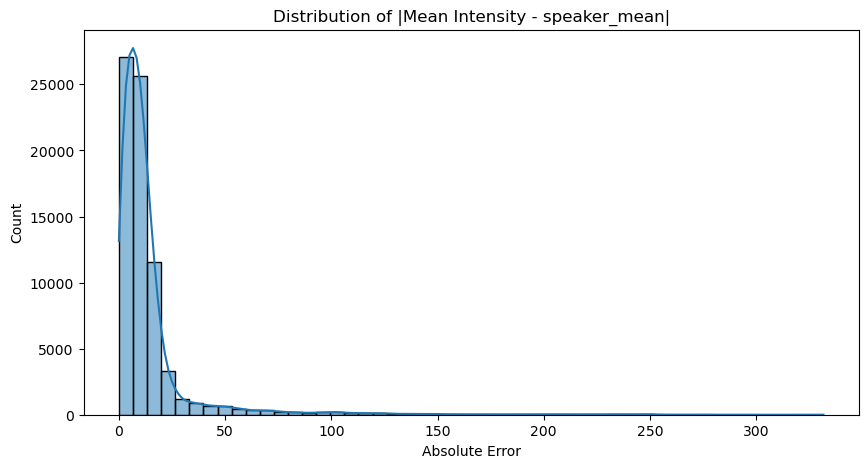

Mean Intensity mean error: 14.1580


In [22]:
speaker_consistency_plot(speech_train, feature='Mean Pitch')
speaker_consistency_plot(speech_train, feature='Mean Intensity')

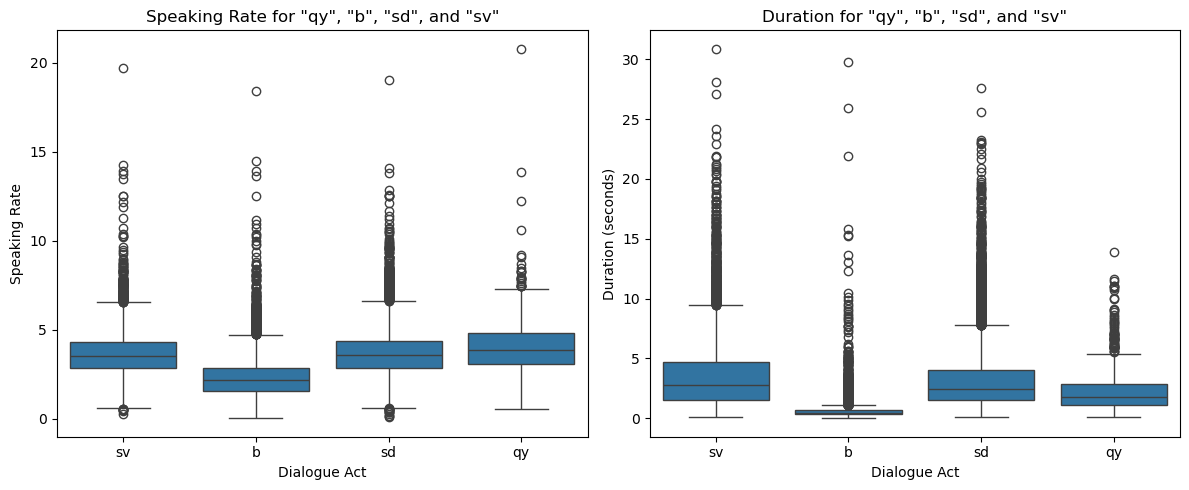

In [52]:
# hypothesis 2: qy and b are high speaking rate and short duration

speech_df = speech_train.copy()
speech_df['duration'] = speech_df['end_time'] - speech_df['start_time']

subset = speech_df[speech_df['da_tag'].isin(['sd', 'sv', 'qy', 'b'])]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='da_tag', y='Speaking Rate', data=subset)
plt.title('Speaking Rate for "qy", "b", "sd", and "sv"')
plt.xlabel('Dialogue Act')
plt.ylabel('Speaking Rate')

plt.subplot(1, 2, 2)
sns.boxplot(x='da_tag', y='duration', data=subset)
plt.title('Duration for "qy", "b", "sd", and "sv"')
plt.xlabel('Dialogue Act')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

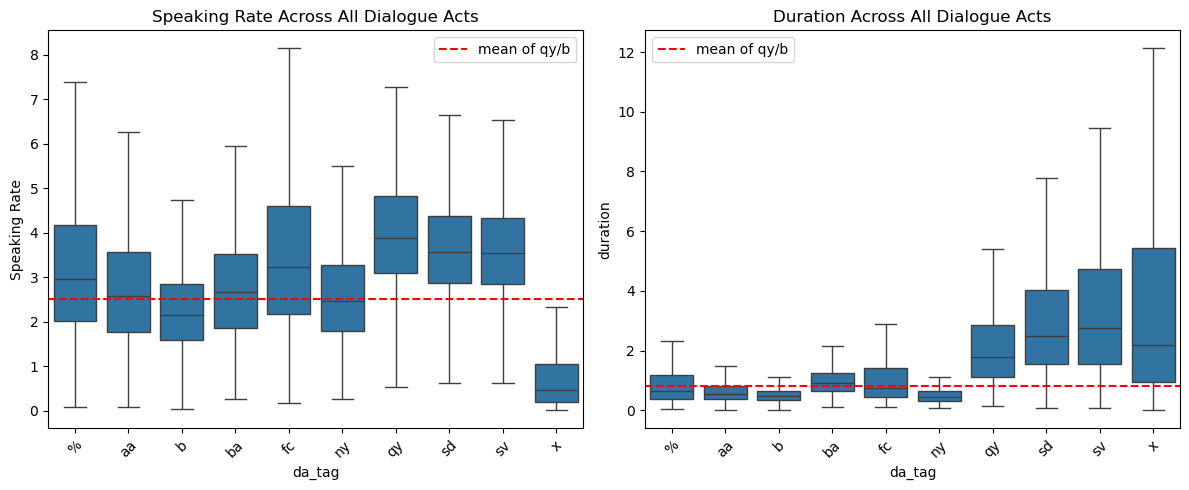

In [46]:
speech_df = speech_train.copy()
speech_df['duration'] = speech_df['end_time'] - speech_df['start_time']

# Plot 1: Speaking Rate
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='da_tag', y='Speaking Rate', data=speech_df, order=sorted(speech_df['da_tag'].unique()), showfliers=False)
plt.axhline(speech_df[speech_df['da_tag'].isin(['qy', 'b'])]['Speaking Rate'].mean(), color='red', linestyle='--', label='mean of qy/b')
plt.title('Speaking Rate Across All Dialogue Acts')
plt.xticks(rotation=45)
plt.legend()

# Plot 2: Duration
plt.subplot(1, 2, 2)
sns.boxplot(x='da_tag', y='duration', data=speech_df, order=sorted(speech_df['da_tag'].unique()), showfliers=False)
plt.axhline(speech_df[speech_df['da_tag'].isin(['qy', 'b'])]['duration'].mean(), color='red', linestyle='--', label='mean of qy/b')
plt.title('Duration Across All Dialogue Acts')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
print(text_train['da_tag'].unique())

['x' 'sv' 'b' 'sd' '%' 'aa' 'ba' 'fc' 'qy' 'ny']


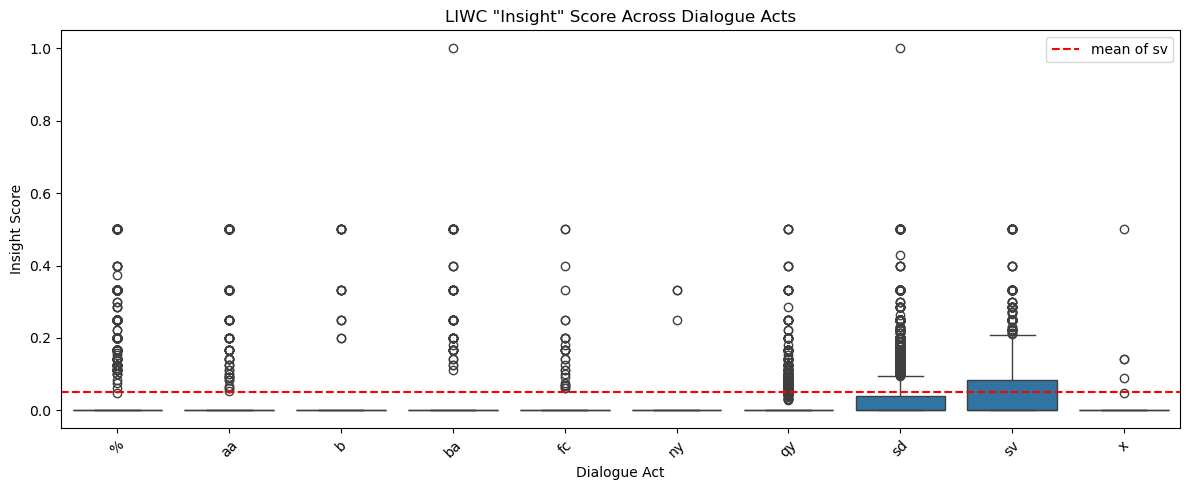

In [48]:
# hypothesis 3

plt.figure(figsize=(12, 5))
sns.boxplot(x='da_tag', y='insight', data=text_train, order=sorted(text_train['da_tag'].unique()))
sv_mean = text_train[text_train['da_tag'] == 'sv']['insight'].mean()
plt.axhline(sv_mean, color='red', linestyle='--', label='mean of sv')
plt.title('LIWC "Insight" Score Across Dialogue Acts')
plt.xlabel('Dialogue Act')
plt.ylabel('Insight Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
from scipy.stats import ttest_ind

sv_values = text_train[text_train['da_tag'] == 'sv']['insight']
others_values = text_train[text_train['da_tag'] != 'sv']['insight']

t_stat, p_val = ttest_ind(sv_values, others_values, equal_var=False)

print(f"T-test result: t = {t_stat:.4f}, p = {p_val:.4f}")

T-test result: t = 42.4252, p = 0.0000


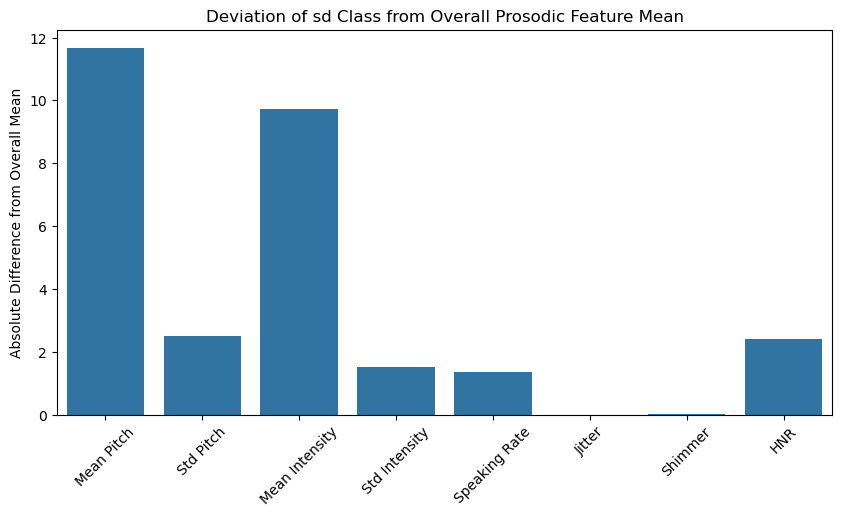

In [40]:
# hypothesis 4

prosodic_features = ['Mean Pitch', 'Std Pitch', 'Mean Intensity', 'Std Intensity', 'Speaking Rate', 'Jitter', 'Shimmer', 'HNR']

diffs = {}
for feat in prosodic_features:
    overall_mean = speech_train[feat].mean()
    sd_mean = speech_train[speech_train['da_tag'] == 'sd'][feat].mean()
    diffs[feat] = abs(sd_mean - overall_mean)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(diffs.keys()), y=list(diffs.values()))
plt.xticks(rotation=45)
plt.ylabel('Absolute Difference from Overall Mean')
plt.title('Deviation of sd Class from Overall Prosodic Feature Mean')
plt.show()

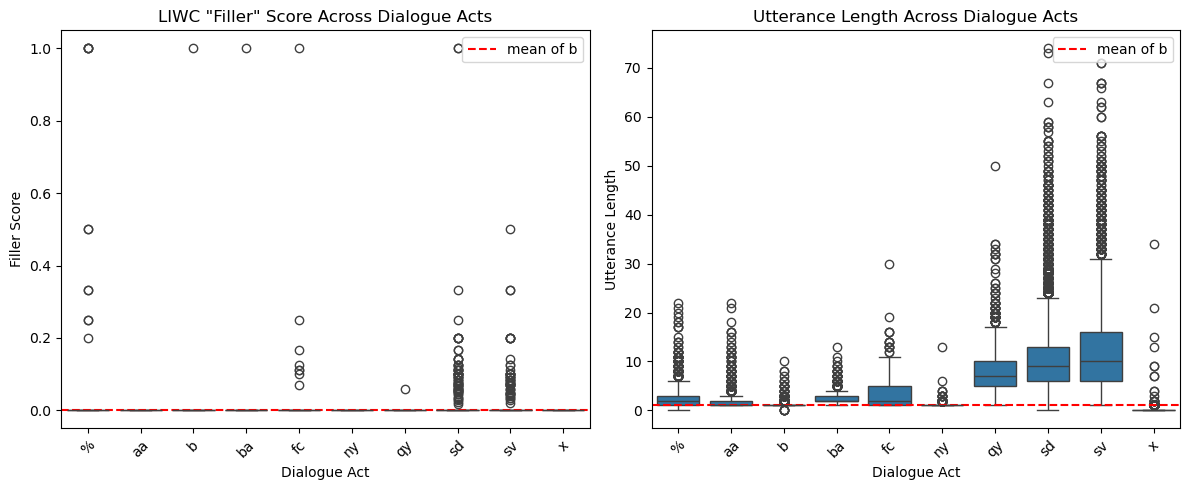

In [44]:
# hypothesis 5

text_df = text_train.copy()

# 1: LIWC Filler
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='da_tag', y='filler', data=text_df, order=sorted(text_df['da_tag'].unique()))
plt.axhline(text_df[text_df['da_tag'] == 'b']['filler'].mean(), color='red', linestyle='--', label='mean of b')
plt.title('LIWC "Filler" Score Across Dialogue Acts')
plt.xlabel('Dialogue Act')
plt.ylabel('Filler Score')
plt.xticks(rotation=45)
plt.legend()

# 2: Utterance Length
plt.subplot(1, 2, 2)
sns.boxplot(x='da_tag', y='utt_len', data=text_df, order=sorted(text_df['da_tag'].unique()))
plt.axhline(text_df[text_df['da_tag'] == 'b']['utt_len'].mean(), color='red', linestyle='--', label='mean of b')
plt.title('Utterance Length Across Dialogue Acts')
plt.xlabel('Dialogue Act')
plt.ylabel('Utterance Length')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
b_filler = text_df[text_df['da_tag'] == 'b']['filler']
other_filler = text_df[text_df['da_tag'] != 'b']['filler']
t_filler, p_filler = ttest_ind(b_filler, other_filler, equal_var=False)
print(f"Filler t = {t_filler:.4f}, p = {p_filler:.4f}")

b_len = text_df[text_df['da_tag'] == 'b']['utt_len']
other_len = text_df[text_df['da_tag'] != 'b']['utt_len']
t_len, p_len = ttest_ind(b_len, other_len, equal_var=False)
print(f"Utterance Length t = {t_len:.4f}, p = {p_len:.4f}")

Filler t = -2.2845, p = 0.0224
Utterance Length t = -138.7938, p = 0.0000
